## 前面这两句话是忽略掉所有警告，免得干扰判断

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 利用sklearn包的随机森林分类器

In [2]:
import pandas
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## 读取sonar.all-data.csv数据集
### 这个数据集是加州大学欧文分校提供的声呐探测数据集，一共有208个样本，60个特征值。
### 数据是声呐照射到物体上反射回来的各种角度、强度等等特征，用来识别被照射物是金属还是岩石
### 结果为M的为金属（metal），R的为岩石（rock）

In [3]:
sonar = pandas.read_csv("./data/sonar.all-data.csv",header=None,prefix='X')

## 修改列名，每个把最后一个列（结果列）的名称改为Label

In [4]:
sonar.rename(columns={'X60':'Label'}, inplace=True)
sonar.Label = sonar.Label.astype('category')

In [5]:
sonar.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X51,X52,X53,X54,X55,X56,X57,X58,X59,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## 把结果改为数值型，主要是在训练的是模型只认数值

In [6]:
sonar["Label"] = sonar["Label"].map({"R":0,"M":1})

### 抽取最后一个列为y 列

In [7]:
data, labels = sonar.iloc[:, :-1], sonar.iloc[:, -1]

### 随机提取33%的数据作为测试子集的样本

In [8]:
X_train, X_test, y_train, y_test = \
  train_test_split(data, labels, test_size=0.33, random_state=44)

### 执行随机森林分类，最大树深度定义为2

In [9]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
pass

### 利用测试子集进行验证，获得分类精度得分

In [10]:
clf.score(X_test, y_test)

0.7101449275362319

### 对列抽样的数量，实际上和分类的精度关系不大

In [11]:
col = sonar.columns.tolist()
x = []
y = []
for i in range(5,len(col)-1):
    x.append(i)
    colname = col[:i]
    colname +=["Label"]
    subsonar = sonar.loc[:,colname]
    data, labels = subsonar.iloc[:, :-1], subsonar.iloc[:, -1]
    X_train, X_test, y_train, y_test = \
      train_test_split(data, labels, test_size=0.33, random_state=44)
    clf = RandomForestClassifier(max_depth=2, random_state=10)
    clf.fit(X_train, y_train)
    y.append(clf.score(X_test, y_test))

## 下面x坐标是参与训练的列的数量，y是分类的得分

<BarContainer object of 55 artists>

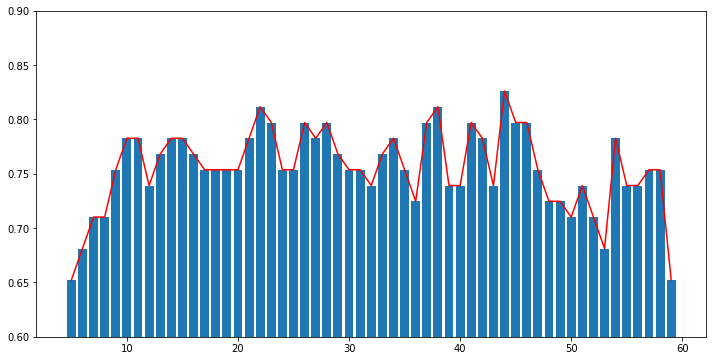

In [12]:
plt.figure(figsize=(12,6))
plt.ylim(0.6,0.9)
plt.plot(x,y,color="r")
plt.bar(x,y)

## 反正相关性都很不咋地

,x,y
x,1.000000,-0.060158
y,-0.060158,1.000000


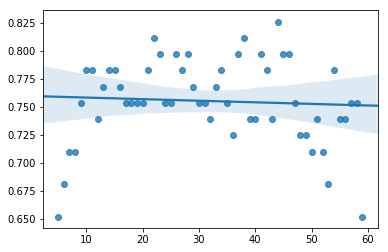

In [13]:
sns.regplot(x,y)
pandas.DataFrame({"x":x,"y":y}).corr()

### max_depth 决策树的最大深度与分类进度的关系

In [14]:
col = sonar.columns.tolist()
x = []
y = []
for i in range(2,15):
    x.append(i)
    data, labels = sonar.iloc[:, :-1], sonar.iloc[:, -1]
    X_train, X_test, y_train, y_test = \
      train_test_split(data, labels, test_size=0.33, random_state=44)
    clf = RandomForestClassifier(max_depth=i, random_state=10)
    clf.fit(X_train, y_train)
    y.append(clf.score(X_test, y_test))

### 发现深度到了10之后，就不再变化了

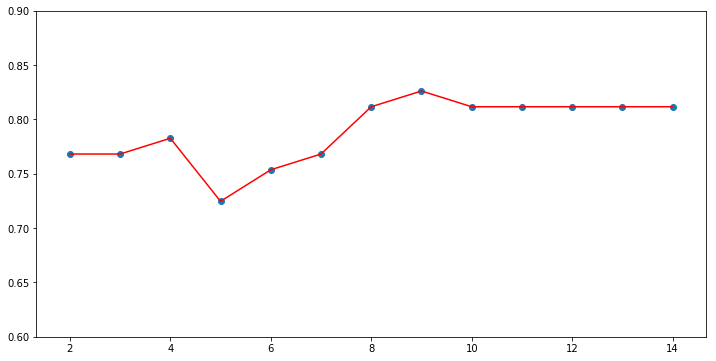

In [15]:
plt.figure(figsize=(12,6))
plt.ylim(0.6,0.9)
plt.plot(x,y,color="r")
plt.scatter(x,y)

## 相关性

,x,y
x,1.000000,0.721342
y,0.721342,1.000000


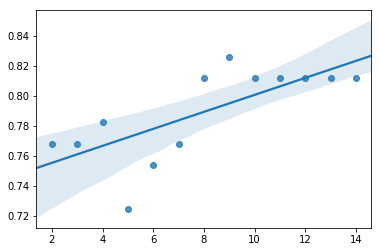

In [16]:
sns.regplot(x,y)
pandas.DataFrame({"x":x,"y":y}).corr()

# 利用GridSearchCV函数进行交叉验证参数优化

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
parameters = [{'n_estimators': list(range(25, 201, 25)),
               'max_features': list(range(2, 15, 2))}]
clf = GridSearchCV(RandomForestClassifier(), parameters,
                   cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)
pass

D:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
clf.best_params_

{'max_features': 2, 'n_estimators': 125}

In [20]:
clf.score(X_test, y_test)

0.782608695652174